# **I. Preparation**

## A. Imports

In [13]:
COLAB_PATH = '/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P7 Modèle de scoring/'
LOCAL_PATH = 'C:\\Users\\benoi\\OneDrive\\Documents\\20.3 Informatique\\Data Science\\0_process\\P7 Modèle de scoring\\40 dossier_git\\'
PATH = LOCAL_PATH

In [14]:
import os
import sys

os.chdir(PATH)
if PATH not in sys.path:
    sys.path.append(PATH)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stat
import pickle
#import xgboost as xgb

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [16]:
sns.set_theme(style="darkgrid")
pd.set_option('display.max_colwidth', None)

In [17]:
!pip install pipreqs
!pipreqs --force

You should consider upgrading via the 'C:\Users\benoi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
INFO: Successfully saved requirements file in C:\Users\benoi\OneDrive\Documents\20.3 Informatique\Data Science\0_process\P7 Modèle de scoring\40 dossier_git\requirements.txt


## B. Uploads

In [18]:
DATA_PATH = PATH + 'eda_data\\'
train_df = pd.read_csv(DATA_PATH + 'app_train.csv', sep=',')
test_df = pd.read_csv(DATA_PATH + 'app_test.csv', sep=',')
cat_col = pd.read_csv(DATA_PATH + 'categorical_features.csv', sep=',')
app_train_df = pd.read_csv(DATA_PATH + 'application_train.csv', sep=',')

## C. Inputs check

In [19]:
train_df.shape

(307508, 306)

In [20]:
test_df.shape

(48744, 305)

([<matplotlib.patches.Wedge at 0x21ae5fa0fd0>,
 [Text(-0.45840470672487627, -0.9999325601521737, 'Train set'),
  Text(0.4584047067248764, 0.9999325601521736, 'Test_set')],
 [Text(-0.25003893094084156, -0.5454177600830038, '86.3'),
  Text(0.2500389309408416, 0.5454177600830037, '13.7')])

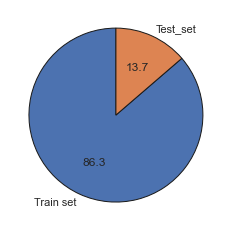

In [21]:
plt.pie(x=[train_df.shape[0], test_df.shape[0]],
        labels=['Train set', 'Test_set'],
        autopct=lambda x: round(x, 1),
        startangle=90,
        wedgeprops={'edgecolor':'k', 'linewidth': 1})

# **II. Modelisation**

## Settings

In [22]:
train_samp_df = train_df.sample(frac=0.2, random_state=1)
test_samp_df = test_df.sample(frac=0.2, random_state=1)
train_samp_df.set_index('SK_ID_CURR', inplace=True)
test_samp_df.set_index('SK_ID_CURR', inplace=True)

In [23]:
X = train_samp_df.drop('TARGET', axis=1)
targets = train_samp_df['TARGET']

In [24]:
# test part will be used to choose the best algorithm
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    targets,
    test_size=0.2,
    random_state=1)

# val part will be used for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.2,
    random_state=1)

## Fonctions

In [25]:
def split_oversample_fit(X, y, model):
    """Perform split, oversampling and fitting on the given X and y sets"""
    # Train / test split
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=1)
    # Oversampling
    X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
    X_resampled = pd.DataFrame(data=X_resampled,
                               columns=X.columns)
    #X_resampled['TARGET'] = pd.Series(y_resampled)
    # Fit the model
    model.fit(X_resampled, y_resampled)

    return model, X_val, y_val


def class_model_perf(X, targets, model):
    """Designed for a binary classification, two categories in total.
    Important: the model must be already instantiated."""

    model, X_val, y_val = split_oversample_fit(X, targets, model)

    # Accuracy
    accuracy = round(model.score(X_val, y_val), 3)
    
    # Confusion matrix elements
    y_pred = model.predict(X_val)
    # Get the false predictions
    pred_dict = dict(pd.Series(y_val - y_pred).value_counts())
    if -1.0 in pred_dict.keys():
        n_FP = pred_dict[-1.0]
    else:
        n_FP = 0
    if 1.0 in pred_dict.keys():
        n_FN = pred_dict[1.0]
    else:
        n_FN = 0
    # Get the true predictions
    temp_dict = dict(pd.Series(2 * y_val - y_pred).value_counts())
    if 1.0 in temp_dict.keys():
        n_TP = temp_dict[1.0]
    else:
        n_TP = 0
    
    try:
        # Precision
        precision = round(n_TP / (n_TP + n_FP), 4)

        # Recall
        recall = round(n_TP / (n_TP + n_FN), 4)
    except ZeroDivisionError:
        return 'n_FP: {}, n_FN: {}, n_TP: {}.'.format(n_FP, n_FN, n_TP)

    # f1 score
    f1 = round(f1_score(y_val, y_pred), 4)

    return 'Accuracy: {}, Precision: {}, Recall: {}, f1-score: {}'.format(
        accuracy, precision, recall, f1)


def list_sample(my_list, chunk):
    """Let a list be given, we select every 'chunk' element.
    Return a list of the selected elements."""
    y = zip(*[iter(my_list)]*chunk)
    return [element[0] for element in y]


def plot_precision_recall_curve(model, X, targets, chunk=1):
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    
    precision, recall, threshold = precision_recall_curve(
        y_val,
        model.predict_proba(X_val)[:, 1])
    f1_score = 2 * precision * recall / (precision + recall)
    # In the cas of overlapping points, select a sample of the lists
    precision = list_sample(precision, chunk)
    precision = np.array(precision)
    recall = list_sample(recall, chunk)
    recall = np.array(recall)
    f1_score = list_sample(f1_score, chunk)
    f1_score = np.array(f1_score)
    max_f1 = round(max(f1_score), 3)

    plt.figure(figsize=(8, 8))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    close_default = np.argmin(np.abs(threshold - 0.5))
    plt.scatter(precision,
                recall,
                s=f1_score*2000,
                c=f1_score,
                cmap='Reds_r',
                edgecolors='k',
                alpha=0.5,
                label='Max f1_score: {}'.format(max_f1))
    plt.plot(precision[close_default//chunk-1],
            recall[close_default//chunk-1],
            '^',
            c='k',
            markersize=10,
            label='Threshold: 0.5',
            fillstyle='none',
            mew=2)
    # ADDITIONAL curves
    x = list(range(0, 100))
    x = [element/100 for element in x]
    # Line of equation y = x
    plt.plot(x, x, color='k', linewidth=1)
    plt.legend(loc='best')
    plt.axis('square')


def prediction_costs(model, X, targets, y_pred=None):
    # Add the prediction errors to the original dataframe
    if type(y_pred) in [list, type(pd.DataFrame()), type(pd.Series())]:
        y_pred = np.array(y_pred)
    if not y_pred.any():
        y_pred = model.predict(X)
    targets = np.array(targets)
    targets = targets.reshape((-1,1))
    y_pred = y_pred.reshape((-1,1))
    X['Prediction error'] = targets - y_pred
    # Create a new feature, multiplying the difference by a money feature.
    # This will be choosen based on feature importances.
    # FP costs
    # log_AMT_ANNUITY_prev: Annuity of previous application
    # AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit.
    # Although useful, it is absent of test set, thus cannot be used. 
    FP_list = []
    for i, row in X.iterrows():
        if X['Prediction error'].loc[i] == -1:
            FP_list.append(-X['Prediction error'].loc[i] *
                           X['log AMT ANNUITY prev'].loc[i])
    FP_sum = sum(FP_list)
    # FN costs
    # log_AMT_ANNUITY: Loan annuity
    FN_list = []
    for i, row in X.iterrows():
        if X['Prediction error'].loc[i] == 1:
            FN_list.append(X['Prediction error'].loc[i] *
                           X['log AMT ANNUITY'].loc[i])
    FN_sum = sum(FN_list)
    # Remove the temporary column from X
    X.drop('Prediction error', axis=1, inplace=True)

    return FP_sum + FN_sum


def costs_estimation(model, X, targets, chunk=1):
    """Evaluate the cost for different values of threshold"""
    # Prepare for y_pred computation
    pred_proba = model.predict_proba(X)
    predict = [element[1] for element in pred_proba]
    precision, recall, thresholds = precision_recall_curve(
        targets,
        model.predict_proba(X)[:, 1])
    
    # In the cas of overlapping points, select a sample of the lists
    precision = list_sample(precision, chunk)
    precision = np.array(precision)
    recall = list_sample(recall, chunk)
    recall = np.array(recall)
    thresholds = list_sample(thresholds, chunk)
    thresholds = np.array(thresholds)

    # Evaluate costs for different values of threshold
    y_costs = []
    for threshold in list(thresholds):
        # Compute y_pred
        y_pred = []
        for element in predict:
            if element >= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        # Compute the costs
        y_costs.append(prediction_costs(model,
                                        X,
                                        targets,
                                        y_pred))

    # Set the 3 lists at the same size
    precision = list(precision)
    recall = list(recall)
    thresholds = list(thresholds)
    temp_min = min(len(precision), len(recall), len(thresholds), len(y_costs))
    precision = precision[:temp_min]
    recall = recall[:temp_min]
    thresholds = thresholds[:temp_min]
    y_costs = y_costs[:temp_min]
    return precision, recall, y_costs, thresholds


def costs_curve(model, X, targets, chunk=1):
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    precision, recall, y_costs, thresholds = costs_estimation(model,
                                                              X_val,
                                                              y_val,
                                                              chunk=chunk)
    # Plot the graph
    plt.figure(figsize=(8, 8))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    thresholds = [element - 0.5 for element in thresholds]
    close_default = np.argmin(np.abs(thresholds))
    plt.scatter(precision,
                recall,
                s=y_costs,
                c=y_costs,
                cmap='Reds',
                edgecolors='k',
                alpha=0.5)
    plt.plot(precision[close_default//chunk-1],
            recall[close_default//chunk-1],
            '^',
            c='k',
            markersize=10,
            label='Threshold: 0.5',
            fillstyle='none',
            mew=2)
    # Line of equation y = x
    x = list(range(0, 100))
    x = [element/100 for element in x]
    plt.plot(x, x, color='k', linewidth=1)
    plt.legend(loc='best')
    plt.axis('square')


def plot_ROC_curve(model, X, targets):
    fpr, tpr, threshold = roc_curve(targets,
                                    model.predict_proba(X)[:, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR (recall)')
    plt.title('ROC curve')
    # Line of equation y = x
    x = list(range(0, 100))
    x = [element/100 for element in x]
    plt.plot(x, x, color='k', linewidth=1)
    plt.axis('square')
    plt.plot(fpr, tpr)


def lowest_costs_param(model, X, targets):
    precision, recall, costs, thresholds = costs_estimation(model,
                                                            X,
                                                            targets)
    precision = [round(element, 2) for element in precision]
    recall = [round(element, 2) for element in recall]
    thresholds = [round(element, 3) for element in thresholds]
    costs = [round(element, 3) for element in costs]
    df = pd.DataFrame({'Precision':precision,
                    'Recall':recall,
                    'Cost':costs,
                    'Threshold':thresholds})
    df.sort_values(by='Cost', inplace=True)
    return dict(df.iloc[0])


def plot_feature_importances(model, X, n_feat):
    """Histogram of the sorted feature importances"""
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    plt.bar(range(len(feature_importances)),
            feature_importances,
            edgecolor='k')


def feature_importance_cumsum(model, df, filter=None):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    forest_importances = pd.Series(importances,
                                   index=X.columns)
    forest_importances.sort_values(ascending=False,
                                   inplace=True)
    if filter:
        # Sort and filter the first 10% 
        ratio = len(forest_importances)//10
        forest_importances = forest_importances[:ratio]
        forest_importances
    plt.plot(forest_importances.cumsum())


def most_important_features(model, X, n_feat=6):
    """Display the n most important feature."""
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    return feature_importances


def plot_important_features(feature_importances):
    plt.barh(feature_importances.index,
             feature_importances)


def prediction_with_threshold(predict_proba, threshold=0.5):
    # Select positive prediction
    predict_proba = predict_proba[:, 1]
    # Form the y_pred
    y_pred = []
    for element in predict_proba:
        if element >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = pd.Series(data=y_pred)
    return y_pred

## A. Dummy classifier

In [26]:
model = DummyClassifier(strategy='constant', constant=1)
class_model_perf(X, targets, model)

'Accuracy: 0.082, Precision: 0.0816, Recall: 1.0, f1-score: 0.1509'

## B. Decision tree

In [27]:
model = DecisionTreeClassifier(max_depth=2)
class_model_perf(X, targets, model)

'Accuracy: 0.756, Precision: 0.1537, Recall: 0.4402, f1-score: 0.2278'

## C. Logistic regression

In [28]:
model = LogisticRegression(C=0.1)
class_model_perf(X, targets, model)

C:\Users\benoi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Accuracy: 0.705, Precision: 0.1666, Recall: 0.6544, f1-score: 0.2656'

## D. SVC

In [29]:
if False:
    model = SVC(gamma=0.05)
    class_model_perf(X, targets, model)

## E. Random forest

In [30]:
model = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
class_model_perf(X, targets, model)

'Accuracy: 0.917, Precision: 0.3514, Recall: 0.0129, f1-score: 0.025'

In [31]:
if False:
    plot_precision_recall_curve(model, X, targets)

In [32]:
if False:
    costs_curve(model, X, targets, chunk=1)

In [33]:
if False:
    lowest_costs_param(model, X, targets)

In [34]:
if False:
    plot_feature_importances(model, X, 250)

In [35]:
if False:
    feature_importance_cumsum(model, X)

In [36]:
# Feature importances: first ones
if False:
    plot_important_features(model, X)

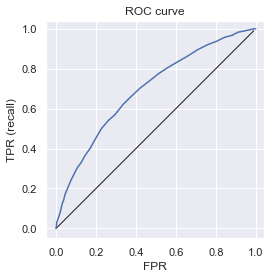

In [37]:
if True:
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    plot_ROC_curve(model, X_val, y_val)


## F. GradientBoosting


In [38]:
if True:
    model = GradientBoostingClassifier()
    class_model_perf(X, targets, model)

In [39]:
if False:
    plot_precision_recall_curve(model, X, targets, 10)

In [40]:
if False:
    costs_curve(model, X, targets, chunk=10)

In [41]:
if False:
    lowest_costs_param(model, X, targets)

In [42]:
if False:
    plot_feature_importances(model, X, 250)

In [43]:
if False:
    feature_importance_cumsum(model, X)

In [44]:
# Feature importances: first ones
if False:
    plot_important_features(model, X)

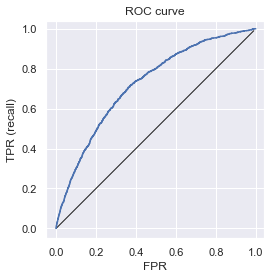

In [45]:
if True:
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    plot_ROC_curve(model, X_val, y_val)

## G. XGBoost

In [46]:
if True:
    model = xgb.XGBClassifier()
    class_model_perf(X, targets, model)

NameError: name 'xgb' is not defined

In [ ]:
if False:
    plot_precision_recall_curve(model, X, targets, 10)

In [ ]:
if False:
    costs_curve(model, X, targets, chunk=10)

In [ ]:
if False:
    lowest_costs_param(model, X, targets)

In [ ]:
if False:
    plot_feature_importances(model, X, 250)

In [ ]:
if False:
    feature_importance_cumsum(model, X)

In [ ]:
# Feature importances: most important ones
if False:
    plot_important_features(model, X)

In [ ]:
if True:
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    plot_ROC_curve(model, X_val, y_val)

# **III. Algorithm optimisation**

As XGBoost has been chosen, we need now to define the **objective function**.

Objective function = Training loss + Regularization.
The general principle is that we want a *simple* and *predictive* model.

**Training loss**
*   measures how predictive our model is with respect to the training data
*   obtained through prediction_costs

**Regularization**
*   controls the complexity of the model,  helps to avoid overfitting

**Challenges ahead**
*   get similar performances on train set & test set
*   taking into account a *balanced* train set and an *imbalanced* test set.
*   big computation time (150 sec for a single 3-fold cross validation)


## A. GridSearchCV

In [47]:
def CV_cost(X, targets, eta, gamma, max_depth, reg_lambda, n_splits=3):
    """
    Perform a cross validation on train set and returns:
    - the average cost on train set
    - the average cost on test set
    """
    # Guarantee a k-fold cross validation
    skfold = StratifiedKFold(n_splits=n_splits)
    # Create the list of costs for each fold
    train_costs = []
    test_costs = []
    for fold, (trainval_idx, test_idx) in enumerate(skfold.split(X,targets),1):
        # Form trainval and test sets
        X_trainval = X.iloc[trainval_idx]
        y_trainval = targets.iloc[trainval_idx]
        X_test = X.iloc[test_idx]
        y_test = targets.iloc[test_idx]
        # Rebalance the dataset with SMOTE oversampling
        sm = SMOTE()
        X_trainval_oversampled, y_trainval_oversampled = sm.fit_sample(
            X_trainval,
            y_trainval)
        
        X_trainval_oversampled = pd.DataFrame(
            data=X_trainval_oversampled,
            columns=X_trainval.columns)
        y_trainval_oversampled = pd.DataFrame(
            data = y_trainval_oversampled,
            columns=['Targets'])
        # Instantiate and fit the model to trainval set
        model = xgb.XGBClassifier(random_state=0,
                                  eta=eta,
                                  gamma=gamma,
                                  max_depth=max_depth,
                                  reg_lambda=reg_lambda)
        model.fit(X_trainval_oversampled,
                  y_trainval_oversampled)
        # Get the threshold giving the lowest cost
        threshold = lowest_costs_param(model,
                                       X_trainval_oversampled,
                                       y_trainval_oversampled)['Threshold']
        # Get predictions on test set
        train_y_pred = prediction_with_threshold(
            model.predict_proba(X_trainval_oversampled),
            threshold)
        test_y_pred = prediction_with_threshold(
            model.predict_proba(X_test),
            threshold)
        # Display the results
        train_costs.append(prediction_costs(model,
                                            X_trainval_oversampled,
                                            y_trainval_oversampled,
                                            train_y_pred))
        test_costs.append(prediction_costs(model,
                                           X_test,
                                           y_test,
                                           test_y_pred))
    # Computation of the average values
    train_cost_avg = stat.mean(train_costs)
    test_cost_avg = stat.mean(test_costs)

    return train_cost_avg, test_cost_avg


def CV_optimisation():
    # Parameters range
    eta_list = [0.1] # learning_rate
    gamma_list = [0.05, 0.1, 0.2] # regularization term
    max_depth_list = [2, 3, 4]
    lambda_list = [1.2]
    # alpha=[], # may be not used if tuning lambda is enough
    scale_pos_weight = 1 # because of high class imbalance
    objective = 'binary:logistic' # for classification problems with probability
    num_feature = 100 # thanks to feature importance evaluation

    scores_df = pd.DataFrame(columns=['eta',
                                      'gamma',
                                      'max_depth',
                                      'reg_lambda',
                                      'Train cost',
                                      'Test cost'])

    for i, eta in enumerate(eta_list):
        row = {}
        row['eta'] = eta
        print('- ', i)
        for ii, gamma in enumerate(gamma_list):
            row['gamma'] = gamma
            print('--- ', ii)
            for iii, max_depth in enumerate(max_depth_list):
                row['max_depth'] = max_depth
                print('------ ', iii)
                for iv, reg_lambda in enumerate(lambda_list):
                    row['reg_lambda'] = reg_lambda
                    print('--------- ', iv)
                    train_cost_avg, test_cost_avg = CV_cost(
                        X, targets,
                        eta, gamma, max_depth, reg_lambda)
                    row['Train cost'] = train_cost_avg
                    row['Test cost'] = test_cost_avg
                    scores_df.loc[scores_df.shape[0]] = row
    # Post-processing
    scores_df.sort_values(by='Test cost', ascending=True, inplace = True)
    scores_df.to_csv(PATH + 'data/' + 'scores.csv')
    # Plot
    train_list = list(scores_df['Train cost'])
    test_list = list(scores_df['Test cost'])

    plt.title('Train / test performances')
    plt.ylabel('Cost')
    plt.plot(train_list, label='Train')
    plt.plot(test_list, label='Test')
    plt.legend()


def plot_DoE(df):
    """Plot design of experiment results"""
    eta_df = df.groupby(by=['eta']).mean()['Test cost']
    eta_df.index = ['min', 'med', 'max']
    gamma_df = df.groupby(by=['gamma']).mean()['Test cost']
    gamma_df.index = ['min', 'med', 'max']
    max_depth_df = df.groupby(by=['max_depth']).mean()['Test cost']
    max_depth_df.index = ['min', 'med', 'max']
    reg_lambda_df = df.groupby(by=['reg_lambda']).mean()['Test cost']
    reg_lambda_df.index = ['min', 'med', 'max']

    plt.title('Step 3')
    plt.xlabel('Parameter values')
    plt.ylabel('Test score')
    plt.plot(eta_df, label='eta')
    plt.plot(gamma_df, label='gamma', color='orange')
    plt.plot(max_depth_df, label='max_depth', color='green')
    plt.plot(reg_lambda_df, label='reg_lambda', color='red')
    plt.legend()

## B. RandomizedSearchCV

In [48]:
if False:
    RS_parameters = {'n_estimators':[80, 120],
                    'max_depth':[3, 7],
                    'max_features':[int(math.sqrt(X_train.shape[0])) + 20,
                                    int(math.sqrt(X_train.shape[0])) - 20],
                    'min_samples_split':[3, 7],
                    'min_samples_leaf':[1, 3],
                    'bootstrap':[True, False]}
    rdm = RandomizedSearchCV(model,
                            RS_parameters,
                            cv=5,
                            n_iter=10,
                            scoring=cost_score)
    rdm.fit(X_train, y_train)
    rdm_best = rdm.best_estimator_
    cost = prediction_costs_for_cv(y_val, rdm_best.predict(X_val))
    cost = round(cost, 2)

# **IV. pickle optimised model**

In [49]:
X = train_samp_df.drop('TARGET', axis=1)
targets = train_samp_df['TARGET']

In [50]:
X.shape, targets.shape

((61502, 304), (61502,))

In [51]:
# Oversampling the whole train set
sm = SMOTE(random_state=0)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X, targets)
#X_train_oversampled.drop('SK_ID_CURR', axis=1, inplace=True)

In [52]:
X_train_oversampled = X_train_oversampled.to_numpy()
y_train_oversampled = y_train_oversampled.to_numpy()

## A. XGBoost

In [ ]:
#model = xgb.XGBClassifier(random_state=0,
#                          eta=0.1,
#                          gamma=0.2,
#                          max_depth=4,
#                          reg_lambda=1.2,
#                          scale_pos_weight = 1,
#                          objective = 'binary:logistic',
#                          eval_metric='logloss')
#model.fit(X_train_oversampled,
#          y_train_oversampled)

In [ ]:
#model.save_model('fitted_xgb.json')

## B. GradientBoosting

In [53]:
model = GradientBoostingClassifier()
model.fit(X_train_oversampled,
          y_train_oversampled)

b'\x80\x04\x95E\x01\x01\x00\x00\x00\x00\x00\x8c\x14sklearn.ensemble._gb\x94\x8c\x1aGradientBoostingClassifier\x94\x93\x94)\x81\x94}\x94(\x8c\x0cn_estimators\x94Kd\x8c\rlearning_rate\x94G?\xb9\x99\x99\x99\x99\x99\x9a\x8c\x04loss\x94\x8c\x08deviance\x94\x8c\tcriterion\x94\x8c\x0cfriedman_mse\x94\x8c\x11min_samples_split\x94K\x02\x8c\x10min_samples_leaf\x94K\x01\x8c\x18min_weight_fraction_leaf\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\tsubsample\x94G?\xf0\x00\x00\x00\x00\x00\x00\x8c\x0cmax_features\x94N\x8c\tmax_depth\x94K\x03\x8c\x15min_impurity_decrease\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\tccp_alpha\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x04init\x94N\x8c\x0crandom_state\x94N\x8c\x05alpha\x94G?\xec\xcc\xcc\xcc\xcc\xcc\xcd\x8c\x07verbose\x94K\x00\x8c\x0emax_leaf_nodes\x94N\x8c\nwarm_start\x94\x89\x8c\x13validation_fraction\x94G?\xb9\x99\x99\x99\x99\x99\x9a\x8c\x10n_iter_no_change\x94N\x8c\x03tol\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x0en_features_in_\x94M0\x01\x8c\x08classes_\x94\x8c\x15nump

In [55]:
filename = 'fitted_gbstg.pkl'
pickle.dump(model, open(filename, 'wb'))